## 5.3 カーネル主成分分析を使った非線形写像


機械学習の多くのアルゴリズムでは、**入力データの線形分離性についての前提**がある。
- 完全に線形分離可能なデータセットが必要：パーセプトロン
- 線形分離性が完全ではないのがノイズによる：ADALINE、ロジスティック回帰、SVM

現実のアプリケーションでは、非線形問題の方がはるかに多い。その場合はPCA、LDAといった線形変換法ではなく**カーネルPCA（KPCA）**を用いる。

KPCAは、線形分離できないデータを高次元変換し、線形分類機に適した新しい低次元の部分空間に射影する。

### 5.3.3 新しいデータ点を射影する




In [2]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    Args: 
        X (NumPy ndarray): shape = [n_samples, n_features].
        gamma (float):  RBF カーネルのチューニングパラメータ
        n_components (int): 返される主成分分析の個数

    Returns:
        (Numpy ndarray): 射影されたデータセット, shape = [n_samples, n_features]
    """
    # MxN 次元のデータセットでペアごとの距離の2乗を計算
    sq_dists = pdist(X, 'sqeuclidean')
    # ペアごとの距離を正方行列に変換
    mat_sq_dists = squareform(sq_dists)
    # 対象カーネル行列を計算
    K = exp(-gamma * mat_sq_dists)
    # 中心化
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # 固有対を取得
    eig_vals, eig_vecs = eigh(K)
    eig_vals, eig_vecs = eig_vals[::-1], eig_vecs[:, ::-1]

    alphas = np.column_stack((eig_vecs[:, i] for i in range(n_components)))
    lambdas = [eig_vals[i] for i in range(n_components)] # 5.3,2 からこの行が追加

    return alphas, lambdas


In [5]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)


<ipython-input-2-f72bbcde3c8b>:9: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  K = exp(-gamma * mat_sq_dists)
<ipython-input-2-f72bbcde3c8b>:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  alphas = np.column_stack((eig_vecs[:, i] for i in range(n_components)))


In [40]:
x_new = X[25]
print('x_new: ', x_new)
x_proj = alphas[25]
print('x_proj: ', x_proj)

def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new-row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)

    return k.dot(alphas / lambdas)

x_new:  [1.8713187  0.00928245]
x_proj:  [0.07877284]


In [41]:
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
print('x_reproj: ', x_reproj)


x_reproj:  [0.07877284]


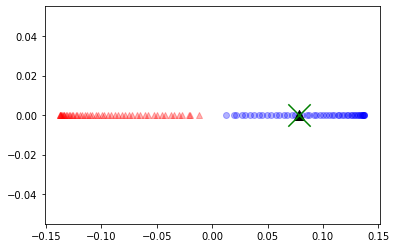

In [42]:
import matplotlib.pyplot as plt  
plt.scatter(alphas[y==0, 0], np.zeros((50)), color='red', marker='^', alpha=0.3)
plt.scatter(alphas[y==1, 0], np.zeros((50)), color='blue', marker='o', alpha=0.3)
plt.scatter(x_proj, 0, color='black', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', marker='x', s=500)
plt.show()

### 5.3.4 scikit-learn のカーネル主成分分析

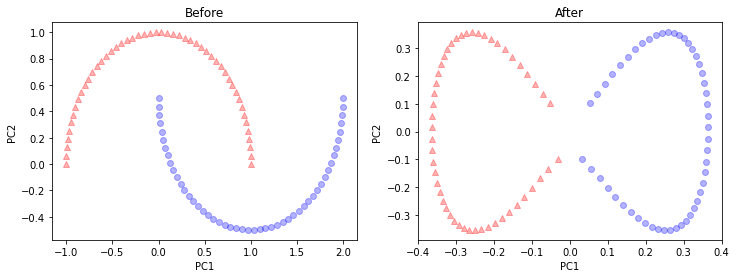

In [1]:
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, random_state=123)

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

fig = plt.figure()
fig.set_size_inches(12, 4)
axes = fig.subplots(ncols=2)
axes[0].scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.3)
axes[0].scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.3)
axes[0].set_title("Before")

axes[1].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.3)
axes[1].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.3)
axes[1].set_title("After")

for i in range(0, 2):
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

plt.show()

#### 参考

- [カーネル法 正定値カーネルを用いたデータ解析 統計数理研究所 福水健次](https://www.ism.ac.jp/~fukumizu/ISM_lecture_2004/Lecture2004_kernel_method.pdf)
  - データを高次元のベクトル空間へ写像し、解析しやすいデータに変換する